# A/B test monitoring

## Initial setup
This first section just ensures that the connection to DWH works correctly.

In [12]:
import pathlib
import yaml
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date



In [13]:
CREDS_FILEPATH = pathlib.Path.home() / ".superhog-dwh" / "credentials.yml"
print(CREDS_FILEPATH)

/home/uri/.superhog-dwh/credentials.yml


In [14]:
# Prepare connection to DWH
# Function to read credentials from the YAML file
def read_credentials(yaml_path: str, env: str = "prd"):
    with open(yaml_path, "r") as file:
        credentials = yaml.safe_load(file)
    return credentials["envs"][env]
# Function to create a PostgreSQL connection string
def create_postgres_engine(creds: dict):
    user = creds["user"]
    password = creds["password"]
    host = creds["host"]
    port = creds["port"]
    database = creds["database"]
    # Create the connection string for SQLAlchemy
    connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(connection_string)
    return engine
# Function to execute a query and return the result as a pandas DataFrame
def query_to_dataframe(engine, query: str):
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df
dwh_creds = read_credentials(yaml_path=CREDS_FILEPATH, env="prd")
dwh_pg_engine = create_postgres_engine(creds=dwh_creds)

In [15]:
# Silly query to test things out
test_df = query_to_dataframe(engine=dwh_pg_engine, query="SELECT 1;")
print(test_df.head())

   ?column?
0         1


## Data Extraction
In this section we extract the data from the Flagging Performance Analysis within DWH.

In [16]:
# Query to extract data
data_extraction_query = """
select *
from intermediate.int_flagging_performance_analysis  
"""

# Retrieve Data from Query
df = query_to_dataframe(engine=dwh_pg_engine, query=data_extraction_query)
print(df.head())

     flagging_analysis_type  count_total  count_true_positive  \
0             RISK_VS_CLAIM         5910                    1   
1  RISK_VS_SUBMITTED_PAYOUT         5894                    1   

   count_true_negative  count_false_positive  count_false_negative  \
0                 5391                   457                    61   
1                 5420                   457                    16   

   true_positive_score  true_negative_score  false_positive_score  \
0             0.000169             0.912183              0.077327   
1             0.000170             0.919579              0.077536   

   false_negative_score  recall_score  precision_score  \
0              0.010321      0.016129         0.002183   
1              0.002715      0.058824         0.002183   

   false_positive_rate_score  f1_score  f2_score  
0                   0.078146  0.003846  0.007082  
1                   0.077761  0.004211  0.009506  


In [281]:
def plot_confusion_matrix_from_df(df, flagging_analysis_type):

    # Subset - just retrieve one row depending on the flagging_analysis_type
    row = df[df['flagging_analysis_type'] == flagging_analysis_type].iloc[0]

    # Define custom x-axis labels and wording
    if flagging_analysis_type == 'RISK_VS_CLAIM':
        x_labels = ['With Submitted Claim', 'Without Submitted Claim']
        outcome_label = "submitted claim"
    elif flagging_analysis_type == 'RISK_VS_SUBMITTED_PAYOUT':
        x_labels = ['With Submitted Payout', 'Without Submitted Payout']
        outcome_label = "submitted payout"
    else:
        x_labels = ['Actual Positive', 'Actual Negative']  
        outcome_label = "outcome"

    # Confusion matrix structure
    cm = np.array([
        [row['count_true_positive'], row['count_false_negative']],
        [row['count_false_positive'], row['count_true_negative']]
    ])

    # Create annotations for the confusion matrix
    labels = [['True Positives', 'False Positives'], ['False Negatives', 'True Negatives']]
    counts = [[f"{v:,}" for v in [row['count_true_positive'], row['count_false_positive']]],
              [f"{v:,}" for v in [row['count_false_negative'], row['count_true_negative']]]]
    percentages = [[f"{round(100*v,2):,}" for v in [row['true_positive_score'], row['false_positive_score']]],
                   [f"{round(100*v,2):,}" for v in [row['false_negative_score'], row['true_negative_score']]]]
    annot = [[f"{labels[i][j]}\n{counts[i][j]} ({percentages[i][j]}%)" for j in range(2)] for i in range(2)]

    # Scores formatted as percentages
    recall = row['recall_score'] * 100
    precision = row['precision_score'] * 100
    f1 = row['f1_score'] * 100
    f2 = row['f2_score'] * 100

    # Set up figure and axes manually for precise control
    fig = plt.figure(figsize=(9, 8))
    grid = fig.add_gridspec(nrows=4, height_ratios=[2, 3, 15, 2])

    
    ax_main_title = fig.add_subplot(grid[0])
    ax_main_title.axis('off')
    ax_main_title.set_title(f"Flagged as Risk vs. {outcome_label.title()}", fontsize=14, weight='bold')
    
    # Business explanation text
    ax_text = fig.add_subplot(grid[1])
    ax_text.axis('off')
    business_text = (
        f"Flagging performance analysis:\n\n"
        f"- Of all the bookings we flagged as at Risk, {precision:.2f}% actually turned into a {outcome_label}.\n"
        f"- Of all the bookings that resulted in a {outcome_label}, we correctly flagged {recall:.2f}% of them.\n"
        f"- The pure balance between these two is summarized by a score of {f1:.2f}%.\n"
        f"- If we prioritise better probability of detection of a {outcome_label}, the balanced score is {f2:.2f}%.\n"
    )
    ax_text.text(0.0, 0.0, business_text, fontsize=10.5, ha='left', va='bottom', wrap=False, linespacing=1.5)

    # Heatmap
    ax_heatmap = fig.add_subplot(grid[2])
    ax_heatmap.set_title(f"Confusion Matrix – Risk vs. {outcome_label.title()}", fontsize=12, weight='bold', ha='center', va='center', wrap=False)

    cmap = sns.light_palette("#318450", as_cmap=True)

    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, cbar=False,
                xticklabels=x_labels,
                yticklabels=['Flagged as Risk', 'Flagged as No Risk'],
                ax=ax_heatmap,
                linewidths=1.0,
                annot_kws={'fontsize': 10, 'linespacing': 1.2})
    ax_heatmap.set_xlabel("Resolution Outcome (Actual)", fontsize=11, labelpad=10)
    ax_heatmap.set_ylabel("Booking Status (Prediction)", fontsize=11, labelpad=10)
    
    # Make borders visible
    for _, spine in ax_heatmap.spines.items():
        spine.set_visible(True)

    # Footer with metrics and date
    ax_footer = fig.add_subplot(grid[3])
    ax_footer.axis('off')
    metrics_text = f"Total Booking Count: {row['count_total']}   |   Recall: {recall:.2f}%   |   Precision: {precision:.2f}%   |   F1 Score: {f1:.2f}%   |   F2 Score: {f2:.2f}%"
    date_text = f"Generated on {date.today().strftime('%B %d, %Y')}"
    ax_footer.text(0.5, 0.7, metrics_text, ha='center', fontsize=9)
    ax_footer.text(0.5, 0.1, date_text, ha='center', fontsize=8, color='gray')

    plt.tight_layout()
    plt.show()

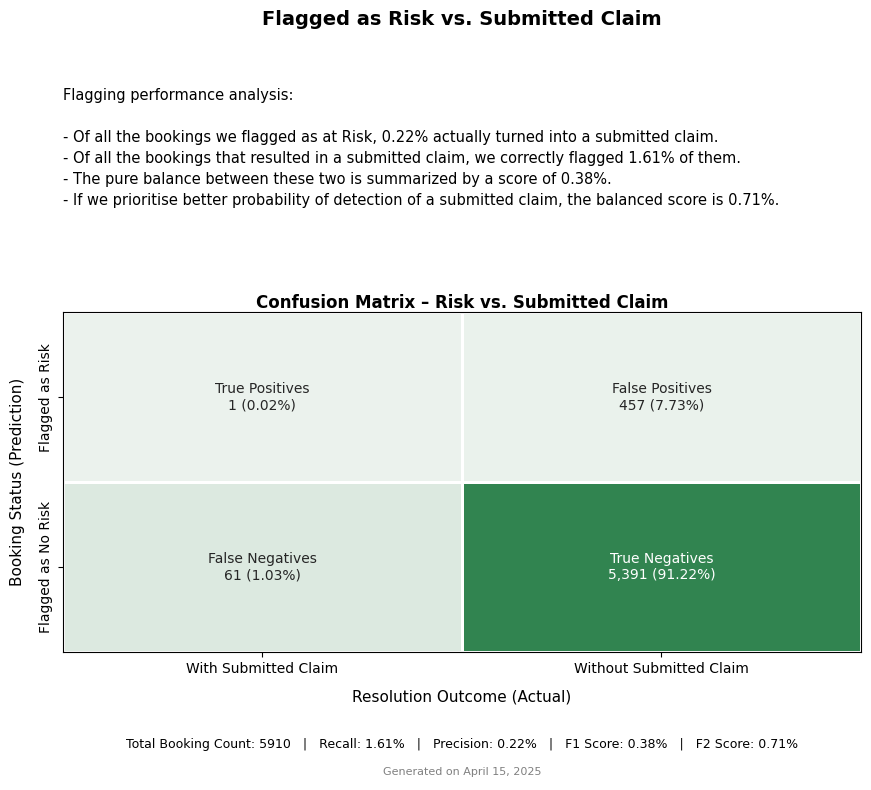

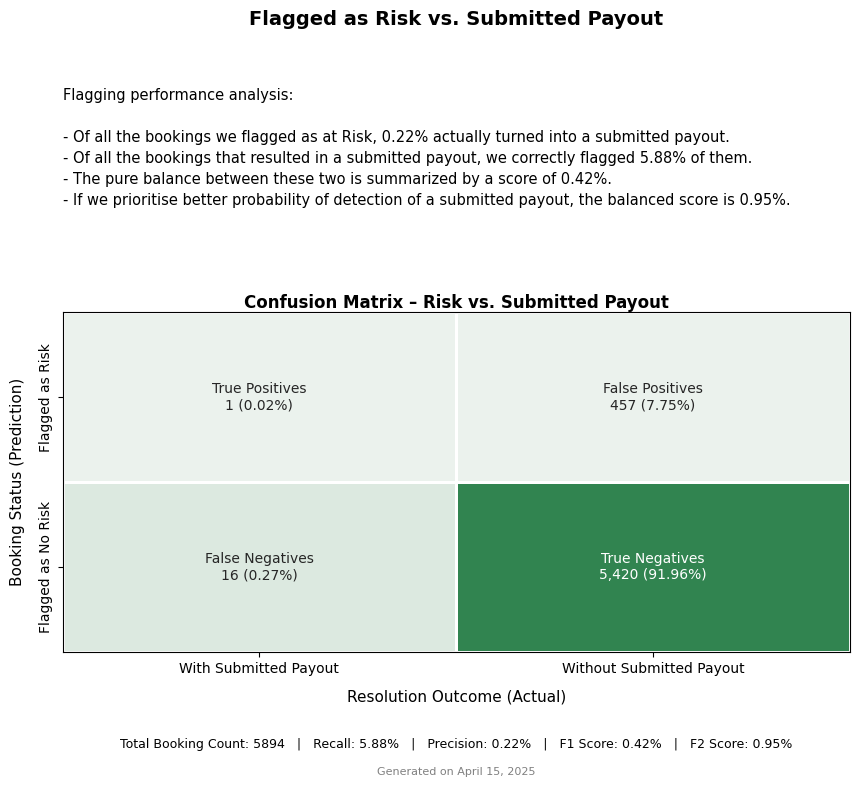

In [282]:
# Plot confusion matrix for claim scenario
plot_confusion_matrix_from_df(df, 'RISK_VS_CLAIM')

# Plot confusion matrix for submitted payout scenario
plot_confusion_matrix_from_df(df, 'RISK_VS_SUBMITTED_PAYOUT')